# 3. Regression
In this notebook we will finally run our regression models. For that purpose, we are importing the necessary libraries and functions from our ```modules``` folder. We are also importing our extracted dataframe

In [1]:
# Warnings
import warnings
warnings.filterwarnings("ignore")

# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from scipy import stats
from functools import reduce

# Statsmodels
import statsmodels.api as sm
import pmdarima as pmd
from pmdarima.arima import auto_arima
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine Learning models
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, ElasticNet, ElasticNetCV, LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    median_absolute_error,
    r2_score,
    precision_score

)

from xgboost import XGBRegressor



In [2]:
# We import our own functions
import sys
sys.path.append('../../..')  # Move two levels up to the project root
from modules.functions import *

In [3]:
df = pd.read_csv('../../../input/df_raw_h08.csv', parse_dates=['Fecha'], index_col='Fecha')
df.tail()

,CPI,CPI Tradable,CPI Non-Tradable,CPI Core,CPI Non-Core,CPI Food and Energy,CPI Excluding Food and Energy,CPI Food and Beverages,CPI Excluding Food and Beverages,CPI Core Excluding Food and Beverages,...,Wholesale Price Index,Reserve Requirement Rate,Monetary Policy Rate,Circulating Currency Seasonally Adjusted (mill S/),Net International Reserves (mill $),Real Minimum Wage (Index),Wheat (US$ per ton),Corn (US$ per ton),Soybean oil (US$ per ton),Crude oil (US$ per barrel)
Fecha,,,,,,,,,,,,,,,,,,,,,
2008-08-01,0.554025,0.356039,0.690723,0.469680,0.666096,0.681738,0.394014,0.755351,0.365874,0.317970,...,0.702300,11.472876,6.25,0.005009,0.002124,-0.005870,-0.012197,-0.160701,-0.156075,-0.128561
2008-09-01,0.565199,0.336413,0.723117,0.481624,0.675909,0.680067,0.422250,0.754096,0.388973,0.335349,...,0.693072,10.787601,6.50,0.017596,-0.006157,-0.005640,-0.125494,-0.006954,-0.078231,-0.103871
2008-10-01,0.576337,0.316247,0.755818,0.493295,0.686014,0.678143,0.450790,0.752209,0.412633,0.352862,...,0.682759,11.862506,6.50,0.003966,-0.079794,-0.006094,-0.206207,-0.260785,-0.244475,-0.267189
2008-11-01,0.587490,0.295514,0.788926,0.504673,0.696555,0.676114,0.479560,0.749865,0.436787,0.370484,...,0.671225,10.084114,6.50,0.006653,-0.030157,-0.003081,0.021940,-0.090908,-0.102564,-0.253950
2008-12-01,0.598682,0.274156,0.822524,0.515746,0.707608,0.674121,0.508447,0.747301,0.461270,0.388144,...,0.658290,12.516334,6.50,-0.005561,0.007297,-0.003589,-0.012756,-0.010237,-0.077524,-0.287431


In [4]:
df_lags = pd.read_csv('../../../input/df_lags_h08.csv', parse_dates=['Fecha'], index_col='Fecha')
df_lags.tail()

,CPI,CPI Tradable_lag_1,CPI Tradable_lag_2,CPI Non-Tradable_lag_1,CPI Non-Tradable_lag_2,CPI Core_lag_1,CPI Core_lag_2,CPI Non-Core_lag_1,CPI Non-Core_lag_2,CPI Food and Energy_lag_1,...,Real Minimum Wage (Index)_lag_1,Real Minimum Wage (Index)_lag_2,Wheat (US$ per ton)_lag_1,Wheat (US$ per ton)_lag_2,Corn (US$ per ton)_lag_1,Corn (US$ per ton)_lag_2,Soybean oil (US$ per ton)_lag_1,Soybean oil (US$ per ton)_lag_2,Crude oil (US$ per barrel)_lag_1,Crude oil (US$ per barrel)_lag_2
Fecha,,,,,,,,,,,,,,,,,,,,,
2008-08-01,0.554025,0.375112,0.393584,0.658619,0.626801,0.457492,0.445103,0.656495,0.646992,0.683126,...,-0.005524,-0.007637,-0.059006,0.021662,-0.085210,0.169325,-0.030379,0.055625,0.000075,0.065257
2008-09-01,0.565199,0.356039,0.375112,0.690723,0.658619,0.469680,0.457492,0.666096,0.656495,0.681738,...,-0.005870,-0.005524,-0.012197,-0.059006,-0.160701,-0.085210,-0.156075,-0.030379,-0.128561,0.000075
2008-10-01,0.576337,0.336413,0.356039,0.723117,0.690723,0.481624,0.469680,0.675909,0.666096,0.680067,...,-0.005640,-0.005870,-0.125494,-0.012197,-0.006954,-0.160701,-0.078231,-0.156075,-0.103871,-0.128561
2008-11-01,0.587490,0.316247,0.336413,0.755818,0.723117,0.493295,0.481624,0.686014,0.675909,0.678143,...,-0.006094,-0.005640,-0.206207,-0.125494,-0.260785,-0.006954,-0.244475,-0.078231,-0.267189,-0.103871
2008-12-01,0.598682,0.295514,0.316247,0.788926,0.755818,0.504673,0.493295,0.696555,0.686014,0.676114,...,-0.003081,-0.006094,0.021940,-0.206207,-0.090908,-0.260785,-0.102564,-0.244475,-0.253950,-0.267189


## 3.1 Benchmark models

In the first section, we first run our benchmark econometric models: ```Random Walk (RW)```,  ```Autoregressive Integrated Moving Average (ARIMA)``` and ```Vector Autoregression (VAR)``` processes

### 3.1.1 Random Walk (RW)

In [5]:
forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# We define our target variable
target = 'CPI'

# We only use CPI as Random Walk is an univariate process
df_CPI = pd.DataFrame(df_lags.CPI)

# We create our train and test set
train_set = df_CPI[df_CPI.index < '2008-01-01']
test_set  = df_CPI[df_CPI.index >= '2008-01-01']

predictions = {}

for h in forecast_horizons:
    # We get the values h horizons before
    predicted_value = train_set.iloc[-1, 0] 

    # We save it for horizon h
    predictions[h] = predicted_value

predicted = pd.DataFrame([predictions]).transpose().reset_index()

predicted.columns = ['Horizon', 'Prediction']

predicted = predicted.set_index(test_set.index)

predicted

,Horizon,Prediction
Fecha,,
2008-01-01,1,0.461849
2008-02-01,2,0.461849
2008-03-01,3,0.461849
2008-04-01,4,0.461849
2008-05-01,5,0.461849
2008-06-01,6,0.461849
2008-07-01,7,0.461849
2008-08-01,8,0.461849
2008-09-01,9,0.461849


In [6]:
# We create our results dataframe, concatenating the predicted and the actual values
results = pd.concat([predicted, test_set[target]], axis=1)
results.rename(columns={'Horizon': 'Horizon', 'Prediction': 'Predicted', 'CPI': 'Actual'}, inplace=True)
results

,Horizon,Predicted,Actual
Fecha,,,
2008-01-01,1,0.461849,0.474129
2008-02-01,2,0.461849,0.485227
2008-03-01,3,0.461849,0.496869
2008-04-01,4,0.461849,0.508551
2008-05-01,5,0.461849,0.520097
2008-06-01,6,0.461849,0.531498
2008-07-01,7,0.461849,0.542800
2008-08-01,8,0.461849,0.554025
2008-09-01,9,0.461849,0.565199


In [7]:
# We get our metrics using our function
RMSE_rw, MAPE_rw = get_metrics(results, 'RW')
metrics_rw = pd.concat([RMSE_rw, MAPE_rw], axis = 1)
metrics_rw

,RMSE_RW,MAPE_RW
1,0.012280,0.025901
2,0.018673,0.037041
3,0.025323,0.048187
4,0.032034,0.059099
5,0.038724,0.069678
6,0.045366,0.079906
7,0.051964,0.089796
8,0.058522,0.099368
9,0.065047,0.108645
10,0.071545,0.117645


### 3.1.2 Autoregressive Integrated Moving Average (ARIMA)

In [8]:
# We only use CPI as Random Walk is an univariate process
df_CPI = pd.DataFrame(df_lags.CPI)

# We create our train and test set
train_set = df_CPI[df_CPI.index < '2008-01-01']
test_set  = df_CPI[df_CPI.index >= '2008-01-01']

In [9]:
# We find the best SARIMA model
autoarima = pmd.auto_arima(
        y = train_set,
        start_p=1,
        start_q=0,
        seasonal=True,
        max_p=12,
        max_d=1,
        max_q=6,
        max_P=12,
        max_D=1,
        max_Q=6,
        m=4,
        n_jobs=-1,
        suppress_warnings=True,
        )

# We indicate the seasonal order for monthly data
seasonal_order = (1, 1, 1, 12)

# We create our ARIMA model
model = SARIMAX(train_set,
                order=autoarima.order,
                seasonal_order=autoarima.seasonal_order,
                enforce_stationarity = False,
                enforce_invertibility = False)
        
# We fit the model
model_fit = model.fit()

# We forecast for the next 12 horizons
forecast_values = model_fit.get_forecast(steps=12)
predicted = pd.DataFrame(forecast_values.predicted_mean, index = test_set.index)

# We create our results dataframe, concatenating the predicted and the actual values
results = pd.concat([predicted, test_set[target]], axis=1)
results.rename(columns={'predicted_mean': 'Predicted', 'CPI': 'Actual'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2008-01-01,0.473018,0.474129
2008-02-01,0.479630,0.485227
2008-03-01,0.483583,0.496869
2008-04-01,0.486860,0.508551
2008-05-01,0.490173,0.520097
2008-06-01,0.493535,0.531498
2008-07-01,0.497540,0.542800
2008-08-01,0.502839,0.554025
2008-09-01,0.509217,0.565199


In [10]:
# We get our metrics using our function
RMSE_arima, MAPE_arima = get_metrics(results, 'ARIMA')
metrics_arima= pd.concat([RMSE_arima, MAPE_arima], axis = 1)
metrics_arima

,RMSE_ARIMA,MAPE_ARIMA
1,0.001111,0.002343
2,0.004035,0.006939
3,0.008348,0.013539
4,0.013034,0.020817
5,0.017748,0.028161
6,0.022421,0.035372
7,0.026898,0.042230
8,0.030993,0.048500
9,0.034671,0.054117
10,0.038001,0.059148


### 3.1.3 Vector autoregression (VAR)

In [11]:
# We define our target variable, as well as our train and test set
target = 'CPI'
train_set = df[df.index < '2008-01-01']
test_set  = df[df.index >= '2008-01-01']

In [12]:
# We model our VAR including up to two lags
model_var = VAR(df)
model_fit = model_var.fit(2)

In [13]:
# We forecast for the next 12 months
preds = model_fit.forecast(df.values[-2:], 12)
preds = pd.DataFrame(preds, index = test_set[target].index)[0]

# We create our results dataframe, concatenating the predicted and the actual values
results = pd.concat([preds, test_set[target]],axis=1)
results.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2008-01-01,0.609283,0.474129
2008-02-01,0.619292,0.485227
2008-03-01,0.628872,0.496869
2008-04-01,0.638122,0.508551
2008-05-01,0.647500,0.520097
2008-06-01,0.657306,0.531498
2008-07-01,0.667995,0.542800
2008-08-01,0.679647,0.554025
2008-09-01,0.692975,0.565199


In [14]:
# We get our metrics using our function
RMSE_var, MAPE_var = get_metrics(results, 'VAR')
metrics_var= pd.concat([RMSE_var, MAPE_var], axis = 1)
metrics_var

,RMSE_VAR,MAPE_VAR
1,0.135154,0.285056
2,0.134610,0.280675
3,0.133747,0.275673
4,0.132715,0.270451
5,0.131670,0.265353
6,0.130711,0.260578
7,0.129938,0.256302
8,0.129406,0.252607
9,0.129226,0.249659
10,0.129542,0.247659


<Axes: >

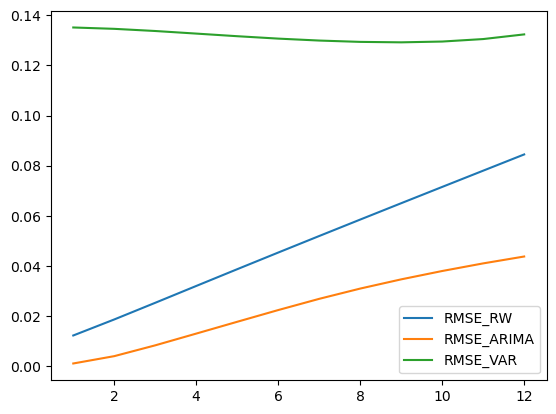

In [15]:
rmse_econometrics = pd.concat([RMSE_rw, RMSE_arima, RMSE_var], axis=1)

rmse_econometrics.plot()

## 3.2 Machine learning models

In the second section, we run our machine learning models: ```Ridge Regression (Ridge)```,  ```Least Absolute Shrinkage and Selection Operator (LASSO)``` and ```Random Forest (RF)``` models

### 3.2.1 Ridge Regression (Ridge)

In [16]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# Implementing the temporal cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2, test_size= 12)

# We implement the model
import sklearn.linear_model as skl
ridge = skl.ElasticNet(l1_ratio=0)
model = ridge

# We define out lambdas and implement our gridparams
lambdas    = np.linspace(0.0001, 1, 1000)

grid_params = {'alpha': lambdas}

# We implement our gridsearch
grid_search = GridSearchCV( model, grid_params, cv = tscv, scoring = 'neg_mean_squared_error')

grid_search.fit( X_train, y_train )

pd.DataFrame( grid_search.cv_results_ )

# And select out best model
best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

In [17]:
pred_vars = X_train.columns.to_list()
coefficients = best_model.coef_
vars_df_ridge      = pd.DataFrame( {'Var': best_model.feature_names_in_, 'Coefficient': coefficients } )
vars_df_ridge      = vars_df_ridge.reindex( vars_df_ridge[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
vars_df_ridge.to_excel( f'../../../output/3_Regression/h08/h08coef_ridge.xlsx' )

In [18]:
# We use the best model to predict
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)
print(y_pred)

Fecha
2008-01-01    0.469864
2008-02-01    0.478197
2008-03-01    0.486769
2008-04-01    0.494961
2008-05-01    0.501813
2008-06-01    0.510479
2008-07-01    0.519535
2008-08-01    0.528825
2008-09-01    0.537004
2008-10-01    0.544017
2008-11-01    0.551577
2008-12-01    0.557662
dtype: float64


In [19]:
# And concatenate the results
results = pd.concat([y_pred, y_test],axis=1)
results.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2008-01-01,0.469864,0.474129
2008-02-01,0.478197,0.485227
2008-03-01,0.486769,0.496869
2008-04-01,0.494961,0.508551
2008-05-01,0.501813,0.520097
2008-06-01,0.510479,0.531498
2008-07-01,0.519535,0.542800
2008-08-01,0.528825,0.554025
2008-09-01,0.537004,0.565199


In [20]:
RMSE_ridge, MAPE_ridge = get_metrics(results, 'Ridge')

<Axes: >

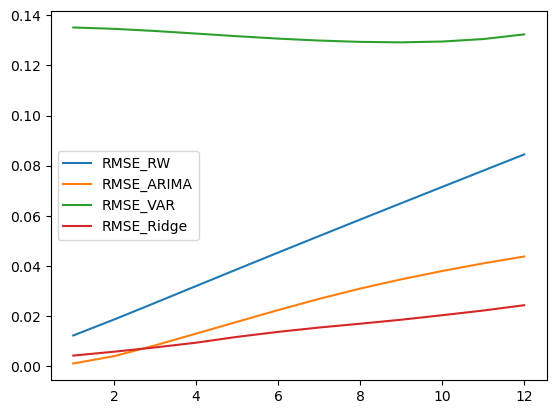

In [21]:
pd.concat([RMSE_rw, RMSE_arima, RMSE_var, RMSE_ridge], axis=1).plot()

### 3.2.2 Lasso Regression (Lasso)

In [22]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# We define the model
import sklearn.linear_model as skl
lasso = skl.ElasticNet( l1_ratio=1, random_state = 2024 )
model = lasso

# We define out lambdas and implement our gridparams
lambdas    = np.linspace(0.0001, 1, 1000)
grid_params = {'alpha': lambdas}

# We implement the gridsearch
grid_search = GridSearchCV( model, grid_params, cv = tscv, scoring = 'neg_mean_squared_error')
grid_search.fit( X_train, y_train )
pd.DataFrame( grid_search.cv_results_ )

best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

In [23]:
pred_vars = X_train.columns.to_list()
coefficients = best_model.coef_
vars_df_lasso      = pd.DataFrame( {'Var': best_model.feature_names_in_, 'Coefficient': coefficients } )
vars_df_lasso      = vars_df_lasso.reindex( vars_df_lasso[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
vars_df_lasso.to_excel( f'../../../output/3_Regression/h08/h08coef_lasso.xlsx' )

In [24]:
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)

In [25]:
results = pd.concat([y_pred, y_test],axis=1)
results.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2008-01-01,0.452707,0.474129
2008-02-01,0.448203,0.485227
2008-03-01,0.444824,0.496869
2008-04-01,0.437793,0.508551
2008-05-01,0.430350,0.520097
2008-06-01,0.425446,0.531498
2008-07-01,0.421874,0.542800
2008-08-01,0.417770,0.554025
2008-09-01,0.412708,0.565199


In [26]:
RMSE_lasso, MAPE_lasso = get_metrics(results, 'Lasso')

<Axes: >

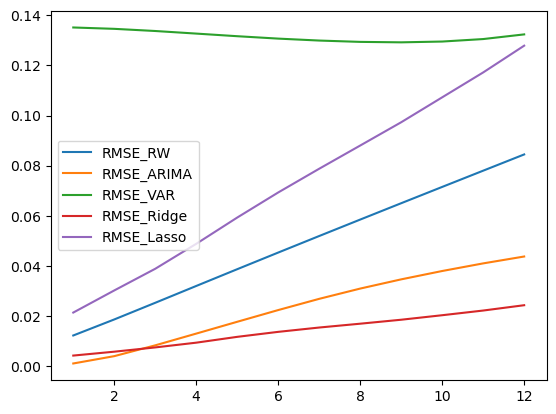

In [27]:
pd.concat([RMSE_rw, RMSE_arima, RMSE_var, RMSE_ridge, RMSE_lasso], axis=1).plot()

### 3.2.3 Random Forest Regression (Random Forest)

In [28]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# Implementing the temporal cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2, test_size= 12)

# We implement the model
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor( random_state = 2024, n_jobs = -1 )
model = random_forest

# We define out lambdas and implement our gridparams
n_estimators = np.arange(5, 16)

# max_depth = np.arange(10, 51)

max_features = [2/3, 1/3, "sqrt", "log2"]

grid_params = {'n_estimators': n_estimators, 'max_features': max_features}

# We implement our gridsearch
grid_search = GridSearchCV( model, grid_params, cv = tscv, scoring = 'neg_mean_squared_error')

grid_search.fit( X_train, y_train )

pd.DataFrame( grid_search.cv_results_ )

# And select out best model
best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

In [29]:
pred_vars = X_train.columns.to_list()
feature_importances = best_model.feature_importances_
vars_df_rf             = pd.DataFrame( {'Var': pred_vars, 'Importance Score': feature_importances } )
vars_df_rf             = vars_df_rf.reindex(vars_df_rf[ 'Importance Score' ].abs().sort_values( ascending = False ).index )
vars_df_rf.to_excel( f'../../../output/3_Regression/h08/h08coef_rf.xlsx' )

In [30]:
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)

In [31]:
results = pd.concat([y_pred, y_test],axis=1)
results.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2008-01-01,0.444173,0.474129
2008-02-01,0.421862,0.485227
2008-03-01,0.389010,0.496869
2008-04-01,0.389804,0.508551
2008-05-01,0.385200,0.520097
2008-06-01,0.394868,0.531498
2008-07-01,0.359141,0.542800
2008-08-01,0.359141,0.554025
2008-09-01,0.357936,0.565199


In [32]:
RMSE_rf, MAPE_rf = get_metrics(results, 'RF')

## 3.3 Results
Here we concat all results into a single dataframe. We export the table to excel.


### 3.3.1 General results
Here we will create graphs and tables with the results of all models combined into a single datagrame.

In [33]:
RMSE_2019 = pd.concat([RMSE_rw, RMSE_arima, RMSE_var, RMSE_ridge, RMSE_lasso, RMSE_rf], axis=1)
MAPE_2019 = pd.concat([MAPE_rw, MAPE_arima, MAPE_var, MAPE_ridge, MAPE_lasso, MAPE_rf], axis=1)

<Axes: >

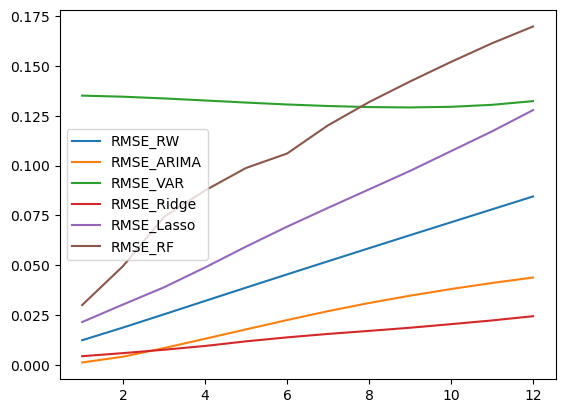

In [34]:
RMSE_2019.plot()

In [35]:
RMSE_2019_results = RMSE_2019.div(RMSE_rw['RMSE_RW'], axis=0)
RMSE_2019_results = RMSE_2019_results.drop(columns=['RMSE_RW'])
RMSE_2019_results_highlight = RMSE_2019_results.style.apply(highlight_min, axis=1)
RMSE_2019_results_highlight

,RMSE_ARIMA,RMSE_VAR,RMSE_Ridge,RMSE_Lasso,RMSE_RF
1,0.090468,11.005631,0.347311,1.744465,2.439396
2,0.216094,7.208826,0.311379,1.619826,2.654167
3,0.329660,5.281672,0.296929,1.535962,2.932749
4,0.406880,4.142888,0.293795,1.524908,2.732409
5,0.458325,3.400246,0.303052,1.532106,2.552369
6,0.494219,2.881234,0.302558,1.528401,2.338192
7,0.517634,2.500533,0.297387,1.516498,2.314355
8,0.529606,2.211249,0.290157,1.504726,2.254200
9,0.533017,1.986668,0.285398,1.496581,2.187282
10,0.531152,1.810640,0.284609,1.499603,2.125933


In [36]:
MAPE_2019_results = MAPE_2019.div(MAPE_rw['MAPE_RW'], axis=0)
MAPE_2019_results = MAPE_2019_results.drop(columns=['MAPE_RW'])
MAPE_2019_results_highlight = MAPE_2019_results.style.apply(highlight_min, axis=1)
MAPE_2019_results_highlight

,MAPE_ARIMA,MAPE_VAR,MAPE_Ridge,MAPE_Lasso,MAPE_RF
1,0.090468,11.005631,0.347311,1.744465,2.439396
2,0.187344,7.577466,0.317003,1.639914,2.615671
3,0.280964,5.720858,0.303053,1.564954,2.842025
4,0.352245,4.576238,0.298371,1.545583,2.725722
5,0.404154,3.808277,0.303359,1.544036,2.593982
6,0.442669,3.261076,0.302931,1.538192,2.421158
7,0.470294,2.854283,0.299244,1.527662,2.384999
8,0.488088,2.542135,0.293833,1.517310,2.328333
9,0.498108,2.297943,0.289901,1.509488,2.267951
10,0.502766,2.105135,0.288619,1.509296,2.212020


In [37]:
tableH19 = RMSE_rw.join(RMSE_2019_results)
tableH19 = tableH19.rename(columns = {'RMSE_RW': 'Benchmark', 'RMSE_ARIMA': 'ARIMA', 'RMSE_VAR': 'VAR', 'RMSE_Ridge': 'Ridge', 
                            'RMSE_Lasso': 'Lasso', 'RMSE_RF':'RF'})
tableH19.index.name = 'horizon'
tableH19.to_excel("../../../output/3_Regression/h08/h08table_rmse.xlsx")

In [38]:
tableH19 = MAPE_rw.join(MAPE_2019_results)
tableH19 = tableH19.rename(columns = {'MAPE_RW': 'Benchmark', 'MAPE_ARIMA': 'ARIMA', 'MAPE_VAR': 'VAR', 'MAPE_Ridge': 'Ridge', 
                            'MAPE_Lasso': 'Lasso', 'MAPE_RF':'RF'})
tableH19.index.name = 'horizon'
tableH19.to_excel("../../../output/3_Regression/h08/h08table_mape.xlsx")

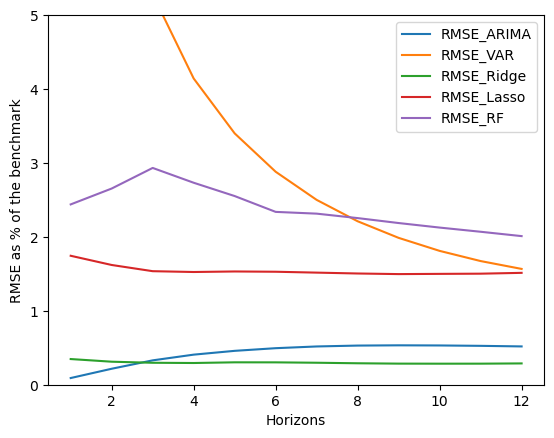

<Figure size 640x480 with 0 Axes>

In [39]:
graph_models(RMSE_2019_results, lim=5)

plt.savefig("../../../output/3_Regression/h08/h08_rmse.png", bbox_inches='tight', dpi=300)

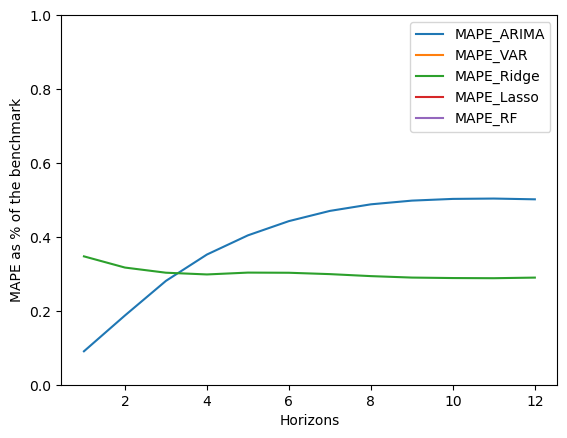

<Figure size 640x480 with 0 Axes>

In [40]:
graph_models(MAPE_2019_results, metric = "MAPE", lim=1)

plt.savefig("../../../output/3_Regression/h08/h08_mape.png", bbox_inches='tight', dpi=300)

### 3.3.2 Coefficients by model

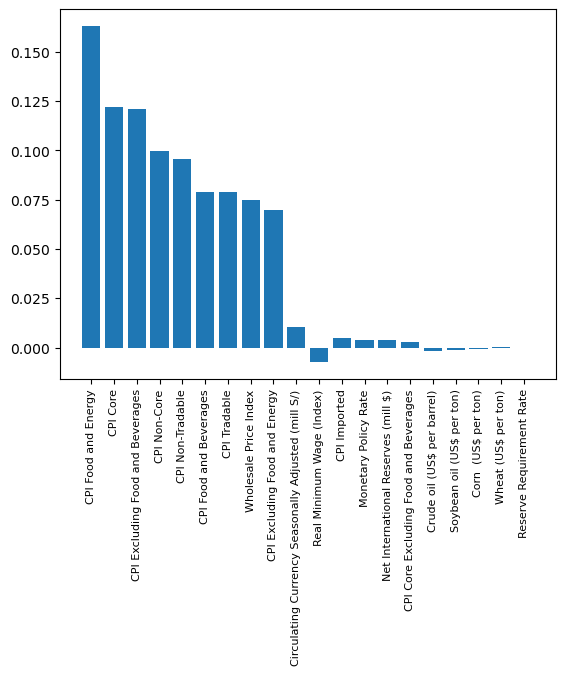

<Figure size 640x480 with 0 Axes>

In [41]:
graph_coefficients(vars_df_ridge, value = "Coefficient")

plt.savefig("../../../output/3_Regression/h08/h08_coef_ridge.png", bbox_inches='tight', dpi=300)

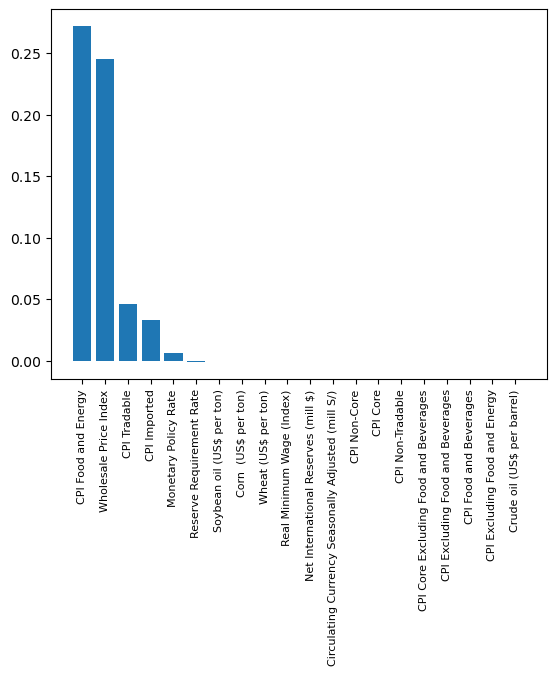

<Figure size 640x480 with 0 Axes>

In [42]:
graph_coefficients(vars_df_lasso, value = "Coefficient")

plt.savefig("../../../output/3_Regression/h08/h08_coef_lasso.png", bbox_inches='tight', dpi=300)

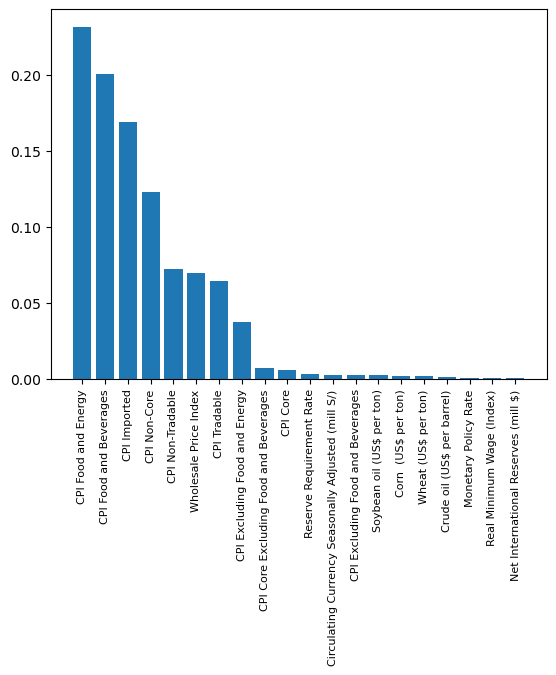

<Figure size 640x480 with 0 Axes>

In [43]:
graph_coefficients(vars_df_rf, value = "Importance Score")

plt.savefig("../../../output/3_Regression/h08/h08_coef_rf.png", bbox_inches='tight', dpi=300)